In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [2]:
ks = [9]#[8, 9, 10, 11]

In [3]:
selfset = {k:set(count_kmers_proteome(human, k, clean=True)) for k in ks}

In [4]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

285467


In [5]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

83870


In [6]:
# only epitopes of lengths in k
mask = df_t['Epitope', 'Description'].apply(len).isin(ks)
df_t = df_t[mask]
print(df_t.shape[0])

45769


In [7]:
# no host epitopes
host = 'Homo sapiens'
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=False)
df_t = df_t[mask]
print(df_t.shape[0])

38800


In [8]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

36172


In [9]:
# only include epitopes of viral origin
#mask = df_t['Epitope', 'Parent Species'].str.contains('virus')
#df_t = df_t[mask]
#print(df_t.shape[0])

In [10]:
df_t['Assay'][['Assay Group', 'Method/Technique']].value_counts().head(20)

Assay Group               Method/Technique                 
IFNg release              ELISPOT                              19869
qualitative binding       multimer/tetramer                     4489
IFNg release              ICS                                   3181
cytotoxicity              51 chromium                           2310
IFNg release              ELISA                                 1015
cytotoxicity              in vitro assay                         751
activation                biological activity                    623
TNFa release              ICS                                    568
IL-2 release              ICS                                    332
dissociation constant KD  surface plasmon resonance (SPR)        311
off rate                  binding assay                          272
degranulation             biological activity                    270
on rate                   binding assay                          267
T cell binding            High throughput m

In [11]:
df_t['Assay', 'Method/Technique'].value_counts().head(10)

ELISPOT                              19935
multimer/tetramer                     4489
ICS                                   4284
51 chromium                           2310
ELISA                                 1327
biological activity                    957
in vitro assay                         789
binding assay                          717
surface plasmon resonance (SPR)        311
High throughput multiplexed assay      229
Name: (Assay, Method/Technique), dtype: int64

In [12]:
# exclude rare assay types
mask = df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(5).index)
df_t_f = df_t[mask]

In [13]:
d0 = df_t_f['Epitope', 'Description'].apply(lambda x: x in selfset[len(x)])

In [14]:
df_t_f[d0]['Epitope', 'Parent Species'].value_counts()

Vaccinia virus                                     68
Mycobacterium tuberculosis                          2
Mus musculus                                        2
Leishmania major                                    2
Human betaherpesvirus 5                             1
Dengue virus                                        1
Human betaherpesvirus 6B                            1
bacterium JGI 053                                   1
Severe acute respiratory syndrome coronavirus 2     1
Name: (Epitope, Parent Species), dtype: int64

In [22]:
df_t_f[d0 & (df_t_f[('Assay', 'Method/Technique')]=='51 chromium')]['MHC']

,Allele Name,Class,Allele IRI,Allele Evidence Code
2940,HLA-A*02:01,I,http://purl.obolibrary.org/obo/MRO_0001007,MHC binding assay


In [16]:
df_t_f[d0]['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             85
No immunization                                                                    15
Occurrence of infectious disease                                                    3
Exposure with existing immune reactivity without evidence for disease               3
Environmental exposure to endemic/ubiquitous agent without evidence for disease     1
Name: (1st in vivo Process, Process Type), dtype: int64

In [17]:
pos_d0 = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_d0_count = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [18]:
pos_all = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_all_count = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [19]:
dfm = pd.merge(pos_d0, pos_all, how='inner', left_index=True, right_index=True, suffixes=['_d0', '_all'])
dfm

,Assay_d0,Assay_all
,Positive,Positive
"(Assay, Method/Technique)",,
51 chromium,0.000000,0.802165
ELISA,0.750000,0.703843
ELISPOT,0.021739,0.200000
ICS,0.333333,0.726891
multimer/tetramer,0.285714,0.748051


In [20]:
px = dfm['Assay_all', 'Positive']
py = dfm['Assay_d0', 'Positive']
ny = pos_d0_count.loc[px.index]['Assay', 'Positive']
nx = pos_all_count.loc[py.index]['Assay', 'Positive']

lower_x, upper_x = statsmodels.stats.proportion.proportion_confint(px*nx, nx, method='jeffreys', alpha=.1)
xerr = (px-lower_x, upper_x-px)
lower_y, upper_y = statsmodels.stats.proportion.proportion_confint(py*ny, ny, method='jeffreys', alpha=.1)
yerr = (py-lower_y, upper_y-py)
yerr

((Assay, Method/Technique)
 51 chromium         -0.001543
 ELISA                0.400707
 ELISPOT              0.015482
 ICS                  0.270921
 multimer/tetramer    0.197599
 dtype: float64,
 (Assay, Method/Technique)
 51 chromium          0.771480
 ELISA                0.203993
 ELISPOT              0.037122
 ICS                  0.431133
 multimer/tetramer    0.307170
 dtype: float64)

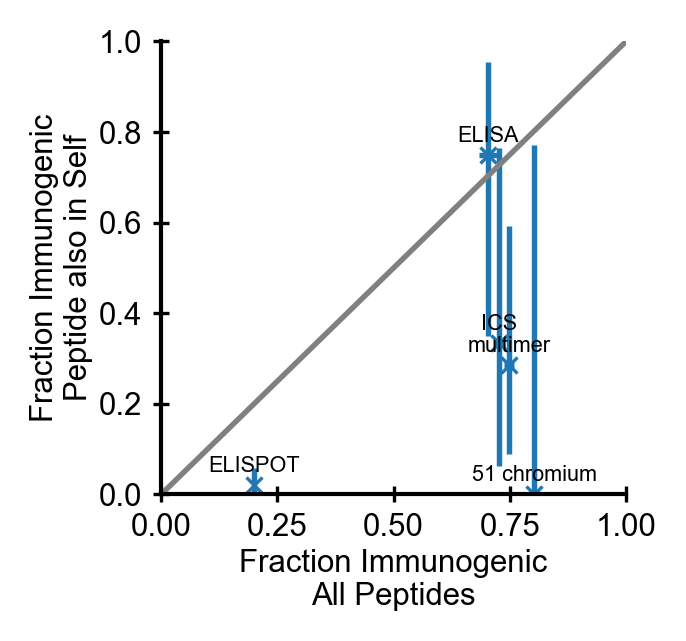

In [25]:
fig, ax = plt.subplots(figsize=(2, 2))
labels = dfm.index
ax.errorbar(px, py, yerr=yerr, xerr=xerr, fmt='x', ms=4)

for x, y, label in zip(px, py, labels):
    plt.annotate(label.split('/')[0], (x, y+0.02),
                 ha='center', va='bottom', size='xx-small')

plt.plot([0, 1], [0, 1], '-', c='.5')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Fraction Immunogenic\nAll Peptides')
plt.ylabel('Fraction Immunogenic\nPeptide also in Self')
fig.savefig(figuredir + 'assays.svg')